In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from scipy.stats import shapiro,bartlett
from statsmodels.stats.stattools import durbin_watson


### Cargar Datos

In [93]:
df = pd.read_csv('2022 MLB Player Stats - Pitching.csv', delimiter=';')


## Ejercicio 1

## Ejercicio 2

### Análisis exploratorio de la variable **Age**, de los jugadores de la liga americana 

Estadísticos descriptivos univariados
Media: 28.78030303030303
Mediana: 29.0
Moda: 0    29
Name: Age, dtype: int64
Desviación estándar: 3.691755816487279
Rango: 20
Cuartiles: 0.25    26.0
0.50    29.0
0.75    31.0
Name: Age, dtype: float64
Rango intercuartílico: 5.0


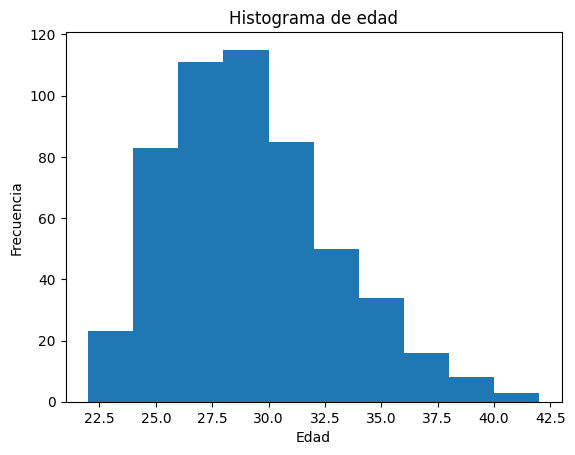

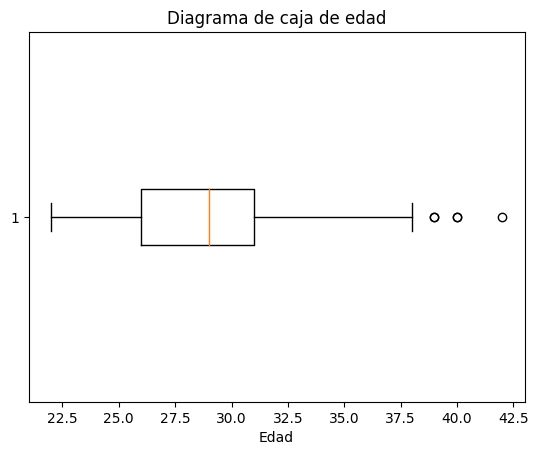

In [94]:
nl = df.loc[df['Lg'] == 'NL']

age = nl['Age']
# Calcular estadísticos descriptivos univariados
mean = age.mean()  # media
median = age.median()  # mediana
mode = age.mode()  # moda
std = age.std()  # desviación estándar
rank = age.max() - age.min()  # rango
quantile = age.quantile([0.25, 0.5, 0.75])  # cuartiles
iqr = quantile[0.75] - quantile[0.25]  # rango intercuartílico


# Mostrar resultados
print('Estadísticos descriptivos univariados')
print('Media:', mean)
print('Mediana:', median)
print('Moda:', mode)
print('Desviación estándar:', std)
print('Rango:', rank)
print('Cuartiles:', quantile)
print('Rango intercuartílico:', iqr)
# Crear histograma
plt.hist(age, bins=10)
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Histograma de edad')

# Crear diagrama de caja
plt.figure()
plt.boxplot(age, vert=False)
plt.xlabel('Edad')
plt.title('Diagrama de caja de edad')

# Mostrar gráficos
plt.show()


### Análisis exploratorio de la variable **Age**, por equipos, de los jugadores de la liga americana

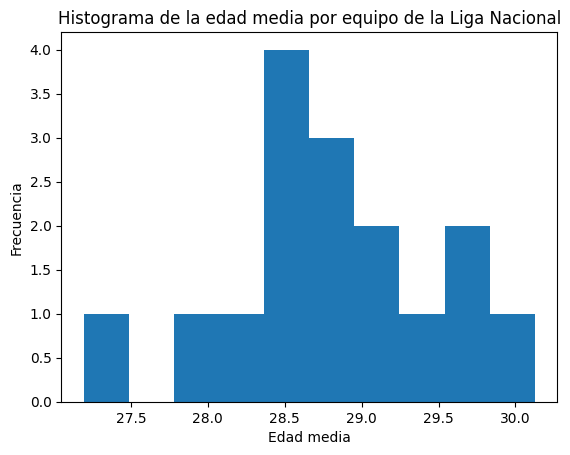

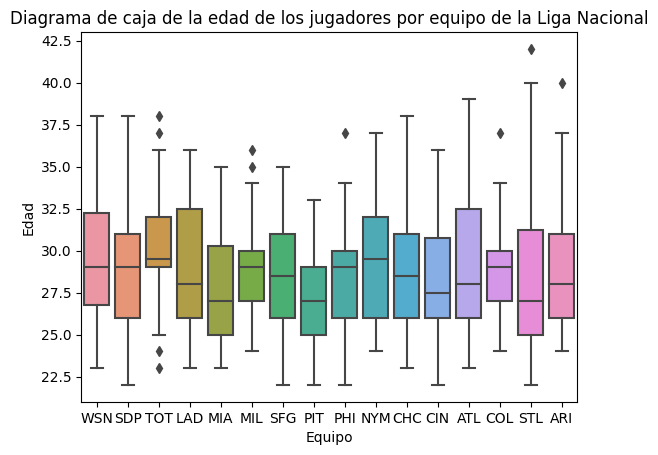

In [95]:
# Agrupar los datos por equipo y calcular la media de la edad de los jugadores
nl_age = nl.groupby('Tm')['Age'].mean()

# Hacer un histograma de la edad media por equipo
plt.hist(nl_age)
plt.xlabel('Edad media')
plt.ylabel('Frecuencia')
plt.title('Histograma de la edad media por equipo de la Liga Nacional')
plt.show()

# Hacer un diagrama de caja de la edad de los jugadores por equipo
sns.boxplot(x='Tm', y='Age', data=nl)
plt.xlabel('Equipo')
plt.ylabel('Edad')
plt.title('Diagrama de caja de la edad de los jugadores por equipo de la Liga Nacional')
plt.show()


### Test Shapiro

In [96]:
def test_shapiro(df, f):
    b = True
    # crear un bucle que recorra la lista
    for i in set(f):

        # seleccionar los datos de las edades de cada equipo
        ages = df[df['Tm'] == i]['Age']

        # realizar la prueba de Shapiro-Wilk
        _, p = shapiro(ages)

        # comparar el valor p con el nivel de significancia
        if p > 0.01:
            b = b and True
        else:
            print('Los datos del equipo %s no parecen normales' % i)
            b = b and False

    return b


### Test Bartlett

In [97]:
def test_bartlett(df, f):
    ages=[]
    # crear un bucle que recorra la lista
    for i in set(f):

        # seleccionar los datos de las edades de cada equipo
        ages.append(df[df['Tm'] == i]['Age'])


    #realizar la prueba de Bartlett
    stat, p = bartlett(*ages)

    print('Bartlett Estadístico: %.3f, Valor p: %.3f' % (stat, p))

    #interpretar el valor p
    if p > 0.01:
        return True
    else:
        print('Las varianzas no parecen iguales')
        return False


### Test Dw

In [98]:
def test_dw(r):
    dw = durbin_watson(r)

    print('Estadístico: %.3f' % dw)

    # interpretar el resultado
    if dw > 1.5 and dw < 2.5:
        return True
    else:
        print('Hay evidencia de autocorrelación')
        return False


### Anova

In [99]:
def mean_age(f, age, nl):

    # Crear el modelo lineal
    model = ols('age ~ f', data=nl).fit()

    # Crear la tabla ANOVA
    table = sm.stats.anova_lm(model, typ=2)
    resid = model.resid

    # Obtener el valor p del test F
    p = table['PR(>F)'][0]

    print('ANOVA de un factor')

    print('El valor p es', p)

    if p >= 0.01 and test_shapiro(nl, f) and test_bartlett(nl, f) and test_dw(resid):
        print('No hay diferencias significativas entre las medias de los equipos')
    else:
        print('Hay diferencias significativas entre las medias de los equipos')


### Inciso a

In [100]:
f = nl['Tm']

mean_age(f, age, nl)


ANOVA de un factor
El valor p es 0.1740010349431162
Los datos del equipo ARI no parecen normales
Los datos del equipo STL no parecen normales
Hay diferencias significativas entre las medias de los equipos


### Inciso b

In [101]:
new_nl = nl[nl['Tm'].isin(['PIT', 'SDP', 'WSN', 'ATL'])]
f = new_nl['Tm']
new_age = new_nl['Age']

mean_age(f, new_age, new_nl)


ANOVA de un factor
El valor p es 0.05367316547657668
Bartlett Estadístico: 10.108, Valor p: 0.018
Estadístico: 1.960
No hay diferencias significativas entre las medias de los equipos


### Inciso c

/tmp/ipykernel_649/218387180.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_nl = nl.groupby('Tm').mean()


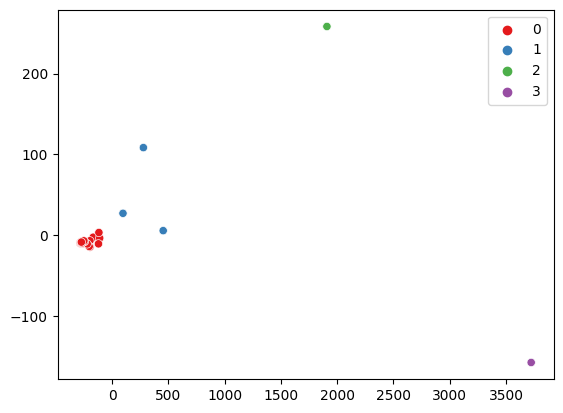

In [102]:
# Agrupar por equipo y calcular medias
new_nl = nl.groupby('Tm').mean()

# Transponer el dataframe
new_nl = new_nl.transpose()

# Convertir a array de numpy
X = new_nl.to_numpy()

# Reducir la dimensión a 2 componentes usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Crear el árbol jerárquico usando AgglomerativeClustering con 4 clústeres
ac = AgglomerativeClustering(n_clusters=4)
C = ac.fit_predict(X_pca)

# Asignar clústeres a equipos
clusters = dict(zip(new_nl.columns, C))

# Visualizar los clústeres usando un gráfico de dispersión con seaborn
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=C, palette='Set1')
plt.show()
